On cherche dans ce projet à modéliser le comportement d'un gaz dans une boîte d'un point de vue thermostatistique, c'est à dire N particules de masse m avec une vitesse initiale identique mais ayant une direction aléatoire.
Ces particules collisionnent de manière élastique entre elles et avec les parois du mur.

On initialise donc d'abbord un réseau de particules distribués de manière égale, puis on associe à chaque particule un vitesse v de direction aléatoire dont les composantes (v_x,v_y) sont calculées à partir d'un angle $\theta$ aléatoire.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = 'C:/ffmpeg/bin/ffmpeg' #Nécessaire au rendu video. L'emplacement de ffmpeg est propre à chaque machine /!\

In [5]:
#On définit les paramètres de la simulation

N=100 #Nombre de particules
mass=1.0e-21 #Masse des particules
radius=0.1 #rayon des particules
L=20 #Longueur de la boite
v_0=2 #Norme des vitesses initiales
duration=10 #Durée de la simulation
dt=0.01 #Intervale de temps
steps=int(duration/dt) #Nombre de pas
kB=1.380649e-23 #Constante de Boltzmann

## Collisions des particules

On cherche a implémenter les collisions des particules avec les murs et entre elles.

#### Les collisions avec les murs :
Quand une particule entre en collision elastique avec un mur elle, sa composante normale au mur est inversée et sa composante orthogonale reste inchangée.

Par exemple pour dans un repère (x, y), pour un mur vertical le long de l'axe y, la composante normale est $v_x$ et la composante orthogonale est $v_y$.

Le code devra tester à chaque instant t si la distance $d$ entre le centre de chaque particules un mur est telle que :

$$d<r$$

#### Les collisions des particules entre elles :

Pour calculer les collisions des particules entre elles, on cherche teste à chaque instant t si les particules se chevauchent.

Si elle se chevauchent, on applique alors :

$$\vec{v_1}^\prime=\vec{v_1}-\frac{2m_2}{m_1+m_2}\frac{(\vec{v_1}-\vec{v_2})\cdot(\vec{r_1}-\vec{r_2})}{\|\vec{r_1}-\vec{r_2}\|^2}(\vec{r_1}-\vec{r_2})$$
$$\vec{v_2}^\prime=\vec{v_2}-\frac{2m_1}{m_1+m_2}\frac{(\vec{v_2}-\vec{v_1})\cdot(\vec{r_2}-\vec{r_1})}{\|\vec{r_2}-\vec{r_1}\|^2}(\vec{r_2}-\vec{r_1})$$

##### Demonstration :

Lors de la collision on définit le vecteur normal $\vec{n}$ comme le vecteur le long de la ligne reliant les centres des particules avec :
$$\vec{n}=\frac{\vec{r_1}-\vec{r_2}}{\|\vec{r_1}-\vec{r_2}\|}$$

$\vec{r_1}$ et $\vec{r_2}$ les vecteur positions des deux particules et le vecteur tangentiel $\vec{t}$ le vecteur orthogonal à $\vec{n}$

Soit les vitesses des deux particules avant collisions :
$$\vec{v_1}\;\;\;\;\vec{v_2}$$
Soit les vitesses des deux particules avant collisions :
$$\vec{v_1}^\prime\;\;\;\;\vec{v_2}^\prime$$

Soit leurs composantes normales :

$$v_{1n}=\vec{v_1}\cdot\vec{n}$$
$$v_{1n}\prime=\vec{v_1}\cdot\vec{n}$$
$$v_{2n}=\vec{v_1}\cdot\vec{n}$$
$$v_{2n}\prime=\vec{v_1}\cdot\vec{n}$$

Soit leurs composantes tangentielles :

$$v_{1t}=\vec{v_1}\cdot\vec{t}$$
$$v_{1t}\prime=\vec{v_1}\cdot\vec{t}$$
$$v_{2t}=\vec{v_1}\cdot\vec{t}$$
$$v_{2t}\prime=\vec{v_1}\cdot\vec{t}$$

Après collision comme les forces de collision s'appliquent le long du vecteur $\vec{n}$, les composantes tangentielles du mouvement restent inchangées par la collision.

Se problème se réduit donc à la résolution d'une collision à 1D le long de l'axe $O_1$ $O_2$.

##### En 1D :

On formule la conservation de la quantité de mouvment et l'énergie cinétique :

$$\vec{p_1}+\vec{p_2}=\vec{p_1}^\prime+\vec{p_2}^\prime\;\;(1)$$
$$E_{C1}+E_{C2}=E_{C1}^\prime+E_{C2}^\prime\;\;(2)$$

Soit :

$$m_1\vec{v_1}+m_2\vec{v_2}=m_1\vec{v_1}^\prime+m_2\vec{v_2}^\prime$$
$$\frac{1}{2}m_1v_1^2+\frac{1}{2}m_2v_2^2=\frac{1}{2}m_1v_1^2\prime+\frac{1}{2}m_2v_2^2\prime$$

On simplifie et regroupe les termes 

$$m_1(v_1-v_1\prime)=m_2(v_2\prime-v_2)$$
$$m_1(v_1^2-v_1^2\prime)=m_2(v_2^2\prime-v_2^2)$$

Si on divise a conservation d'énergie cinétique par celle de la quantité de mouvment :

$$\frac{(v_1-v_1\prime)(v_1+v_1\prime)}{(v_1-v_1\prime)}=\frac{(v_2\prime-v_2)(v_2\prime+v_2)}{(v_2\prime-v_2)}$$

Et ainsi on a la relation :
$$v_1-v_2=-(v_1\prime-v_2\prime)\;\;(3)$$

On a utilise la relation $(3)$ dans $(1)$ :

$$v_1=v_2+v_2\prime-v_1$$

$$m_1v_1+m_2v_2=m_1(v_2+v_2\prime-v_1)+m_2v_2\prime$$
$$v_2\prime(m_1+m_2)=m_1v_1+m_2v_2-m_1(v_2-v_1)$$
$$v_2\prime(m_1+m_2)=(m_2-m-1)v_2+2m_1v_1$$

Et donc :

$$\boxed{v_2\prime=\frac{(m_2-m_1)v_2+2m_1v_1}{(m_1+m_2)}}$$
et de manière analogue :
$$\boxed{v_1\prime=\frac{(m_1-m_2)v_1+2m_1v_2}{(m_1+m_2)}}$$

##### On applique les solutions normales au problème en 2D :

Les vitesse après collisions s'exprimment :

$$\vec{v_1}\prime=\vec{v_{1n}}\prime+\vec{v_{1t}}$$
$$\vec{v_2}\prime=\vec{v_{2n}}\prime+\vec{v_{2t}}$$

Et on sait que :
$$\vec{v_n}=(\vec{v}\cdot\vec{n})\vec{n}$$
$$\vec{v_t}=\vec{v}-(\vec{v}\cdot\vec{n})\vec{n}$$

Donc :

$$\vec{v_{1n}}\prime=\left[\frac{(m_1-m_2)(v_1\cdot\vec{n})+2m_2(\vec{v_2}\cdot\vec{n})}{(m_1+m_2)}\right]\vec{n}$$
$$\vec{v_{2n}}\prime=\left[\frac{(m_2-m_1)(v_2\cdot\vec{n})+2m_1(\vec{v_1}\cdot\vec{n})}{(m_1+m_2)}\right]\vec{n}$$

Pour $\vec{v_1}$ :

$$\vec{v_1}\prime=\vec{v_{1n}}\prime+\vec{v_{1t}}$$

$$\vec{v_{1n}}\prime=\left[\frac{(m_1-m_2)(v_1\cdot\vec{n})+2m_2(\vec{v_2}\cdot\vec{n})}{(m_1+m_2)}\right]\vec{n}+\vec{v_1}-(\vec{v_1}\cdot\vec{n})\vec{n}$$

$$\vec{v_{1n}}\prime=\vec{v_1}+\left[\frac{(m_1-m_2)(v_1\cdot\vec{n})}{(m_1+m_2)}+\frac{2m_2(\vec{v_2}\cdot\vec{n})}{m_1+m_2}-(\vec{v_1}\cdot\vec{n})\right]\vec{n}$$

$$\vec{v_{1n}}\prime=\vec{v_1}+\left[\frac{(-2m_2)}{(m_1+m_2)}(v_1\cdot\vec{n})+\frac{2m_2}{m_1+m_2}(\vec{v_2}\cdot\vec{n})\right]\vec{n}$$
On obtient donc :

$$\boxed{\vec{v_1}^\prime=\vec{v_1}-\frac{2m_2}{m_1+m_2}\frac{(\vec{v_1}-\vec{v_2})\cdot(\vec{r_1}-\vec{r_2})}{\|\vec{r_1}-\vec{r_2}\|^2}(\vec{r_1}-\vec{r_2})}$$
Et analoguement :

$$\boxed{\vec{v_2}^\prime=\vec{v_2}-\frac{2m_1}{m_1+m_2}\frac{(\vec{v_2}-\vec{v_1})\cdot(\vec{r_2}-\vec{r_1})}{\|\vec{r_2}-\vec{r_1}\|^2}(\vec{r_2}-\vec{r_1})}$$

In [ ]:
#La fonction meshCreation crée un réseau régulier de particules dans la boit de longueur L.
def meshCreation(N, L, radius):
    grid_points=int(np.ceil(np.sqrt(N))) #On crée les paramètres de la grille. Prendre l'arrondi de la racine de N assure que (N+1)>=grid^2>=N.
    space=L/grid_points #On calcule l'espacement de chaque particules.
    x=np.linspace(radius+space/2, L-radius - space/2, grid_points) #On crée une rangée de particules

    X_mat,Y_mat=np.meshgrid(x,x, indexing='ij') #On crée à l'aide de la fonction meshgrid de NumPy une matrice des positon pour chaque coordonnées (x, y).
    x, y = X_mat.ravel(), Y_mat.ravel() #On convertit les matrices en array NumPy 1D.
    position=np.stack((x, y)).T #On stack et transpose les deux array de coordonnées de manière à obtenir un array contenant la liste des coordonnées x et y pour un maillage grid^2.

    return position[:N] #On retourne un slice jusque à N de l'array position pour n'avoir que N particules (grid^2>N).

#La fonction velocityInit crée un tableau des composantes x et y des vitesses initiales des particules.
def velocityInit(N):
    theta=np.random.uniform(0, 2*np.pi, size=N) #On crée un array 1D de taille N contenant des valeur aléatoires de 0 à 2pi.
    v_x,v_y=v_0*np.cos(theta), v_0*np.sin(theta) #On calcule les composante (v_x, v_y) des vecteurs v_n d'angles relatif à la particule aléatoires et de norme fixe v_0.
    velocity=np.stack((v_x,v_y), axis=1) #On stack ces valeurs dans un seul array 2D pour chaque composantes.
    return velocity

def collisions(position, velocity, radius, L, dt, N):
    position_next = position + velocity * dt #On calcule l'array position pour (t+dt).

    #Les arrays velocity position et position_next étant tous trois des arrays (N,2) on peux utiliser le boolean masking ici.

    velocity[position_next[:, 0] < radius, 0] *= -1
    """
    Cette ligne de code ci dessus applique la collision élastique des particules (voir section plus sur les collisions) au mur de gauche
    Les éléments (N,0) de velocity pour lesquels position_next[:, 0] (c'est à dire l'ensemble des coordonnées x de position_next)
    sont inférieur à 1 radius se voient appliquer l'opération *(-1).
    C'est équivalent à une boucle for qui parcours les éléments (N,0) de velocitiy (c'est à dire pour ce cas les éléments orthogonaux) et qui applique la
    condition if (positon_next[:, 0] < radius).
    Néanmoins la vectorisation avec NumPy permet des gains de performance.
    """
    velocity[position_next[:, 0] > L - radius, 0] *= -1 #Code identique pour le mur de droite
    velocity[position_next[:, 1] < radius, 1] *= -1 #Code identique pour le mur du bas
    velocity[position_next[:, 1] > L - radius, 1] *= -1 #Code identique pour le mur du haut

    for i in range(N):
        for j in range(i + 1, N):
            """
            On cherche à calculer quelles particules pourraient entrer en collisions entre elles à un instant t.
            Pour se faire on parcours d'abord les N particules avec un boucle for.
            Pour chacune des particules on teste les N-(i+1) particules.
            En effet pas besoin de tester les N-1 particules. Si on prend la première particule P1 on teste N-1 particules (P1<->P2; P1<->P3; ...;P1<->P(N-1)).
            Quand on teste la deuxième, inutile de tester la paire P1 et P2 car ce calcul a déjà eu lieu lors du test pour P1.
            """
            if np.linalg.norm(position_next[i] - position_next[j]) < 2 * radius: #On teste si la distance entre les deux particules considérée est < 2 radius.

                # On applique les formules détailées dans la section collision (ici les masses sont identiques donc s'annulent)

                delta_velocity = velocity[i] - velocity[j]
                delta_r = position[i] - position[j]

                velocity[i] -= delta_r.dot(delta_velocity) / (delta_r.dot(delta_r)) * delta_r
                velocity[j] += delta_r.dot(delta_velocity) / (delta_r.dot(delta_r)) * delta_r

def step(position, velocity, radius, L, dt, N):
    collisions(position, velocity, radius, L, dt, N) #On calcule les collision pour un step.
    position += velocity * dt #On met à jour l'array position.
    #Redondance

def simulation(position, velocity, radius, L, dt, N, steps):
    positions = np.zeros((steps, N, 2)) #On crée un array positions qui stocke l'entièreté des positons pour chaque pas de temps
    velocities = np.zeros((steps, N))#On crée un array velocities qui stocke l'entièreté des vitesses pour chaque pas de temps.

    for i in range(steps): #On parcours chaques step.
        step(position, velocity, radius, L, dt, N) #On applique la fonction step qui calcule nos postions et vitesses
        positions[i, :, :] = position #On place l'entièreté de l'array position dans l'array 3D positions.
        velocities[i, :] = np.linalg.norm(velocity, axis=1) # On place la norme des vitesses dans l'array 2D velocities.

    return positions, velocities

def update(frame):
    axis_1.clear()
    for i in range(N):
        x, y = positions[frame,i, 0], positions[frame, i, 1]
        circle = plt.Circle((x, y), radius, fill=True)
        axis_1.add_artist(circle)

    axis_1.set_xlabel('$X$', fontsize=15)
    axis_1.set_ylabel('$Y$', fontsize=15)
    axis_1.set_title("Animation d'un gaz parfait", fontsize=15)
    axis_1.set_xlim(0, L)
    axis_1.set_ylim(0, L)
    axis_1.set_aspect('equal')
    axis_1.set_xticks([])
    axis_1.set_yticks([])
    plt.tight_layout()

def temperature(v_0, mass):
    E_c_avrg=0.5*mass*(v_0**2)
    T=E_c_avrg/kB
    return T

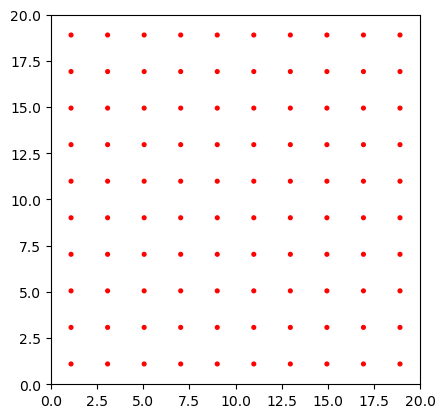

In [7]:
particles_position=meshCreation(N, L, radius) # On initialise le réseau de particules.

particle_velocity=velocityInit(N) # On initialise les vitesses des particules du réseau.

# On affiche le réseau de particules :
fig=plt.figure()
axis_1=fig.add_subplot(111)
for(x,y) in particles_position:
    axis_1.add_artist(plt.Circle((x,y), radius, color='r'))
axis_1.set_xlim(0, L)
axis_1.set_ylim(0, L)
axis_1.set_aspect('equal')
plt.show()

# On simule pour chaque pas de temps les collisions :
positions, velocities = simulation(particles_position, particle_velocity, radius, L, dt, N, steps)


In [ ]:
fig,ax1= plt.subplots(1, figsize = (12,6))

interval = duration*1e3/steps
animation = FuncAnimation(fig, update, frames=steps, interval=interval)
HTML(animation.to_html5_video())

In [ ]:
T=temperature(v_0, mass)
print("Temperature", np.round(T,2), "K")

Temperature 144.86 K
